# Market Cap Visualization
## IDX Stocks - Marketcap Analysis & Heatmap

In [1]:
import pandas as pd
import numpy as np
import mysql.connector
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os

# Setup
project_root = '/Users/cevin/Documents/QuantResearch'
os.chdir(project_root)
sys.path.insert(0, project_root)
from config.settings import DB_CONFIG

# Set style
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (14, 8)

def get_market_data():
    """Get all market data from database"""
    conn = mysql.connector.connect(**DB_CONFIG)
    cursor = conn.cursor()
    cursor.execute("SELECT ticker, marketcap_idr FROM market_data ORDER BY marketcap_idr DESC")
    rows = cursor.fetchall()
    cursor.close()
    conn.close()
    return pd.DataFrame(rows, columns=['ticker', 'marketcap_idr'])

def format_currency(value):
    """Format value as IDR currency"""
    if pd.isna(value) or value == 0:
        return "N/A"
    if value >= 1e12:
        return f"Rp {value/1e12:.2f}T"
    elif value >= 1e9:
        return f"Rp {value/1e9:.2f}B"
    elif value >= 1e6:
        return f"Rp {value/1e6:.2f}M"
    else:
        return f"Rp {value:,.0f}"

# Load data
market_data = get_market_data()

print("✅ Setup complete")
print(f"📊 Total stocks: {len(market_data)}")
print(f"📍 Database: {DB_CONFIG['database']}")

✅ Setup complete
📊 Total stocks: 952
📍 Database: quantresearch_db


## Top 10 Marketcap Stocks

In [2]:
# Get top 10
top_10 = market_data.head(10).copy()
top_10['marketcap_formatted'] = top_10['marketcap_idr'].apply(format_currency)
top_10['percentage'] = (top_10['marketcap_idr'] / market_data['marketcap_idr'].sum() * 100).round(2)

# Display
display_table = top_10[['ticker', 'marketcap_formatted', 'percentage']].copy()
display_table.columns = ['Ticker', 'Marketcap', '% of Total']
display_table = display_table.reset_index(drop=True)
display_table.index = display_table.index + 1

print("\n🏆 TOP 10 STOCKS BY MARKETCAP")
print("="*70)
print(display_table.to_string())
print("="*70)
print(f"\n💰 Combined Top 10 Marketcap: {format_currency(top_10['marketcap_idr'].sum())}")
print(f"📊 % of Total Market: {top_10['percentage'].sum():.2f}%")


🏆 TOP 10 STOCKS BY MARKETCAP
   Ticker    Marketcap  % of Total
1    BREN  Rp 1073.63T        7.57
2    BBCA   Rp 944.13T        6.66
3    TPIA   Rp 614.18T        4.33
4    BBRI   Rp 572.89T        4.04
5    DSSA   Rp 528.41T        3.73
6    AMMN   Rp 525.76T        3.71
7    DCII   Rp 520.97T        3.67
8    BYAN   Rp 485.83T        3.43
9    BMRI   Rp 471.33T        3.32
10   TLKM   Rp 334.83T        2.36

💰 Combined Top 10 Marketcap: Rp 6071.96T
📊 % of Total Market: 42.82%


## Marketcap Distribution Visualization

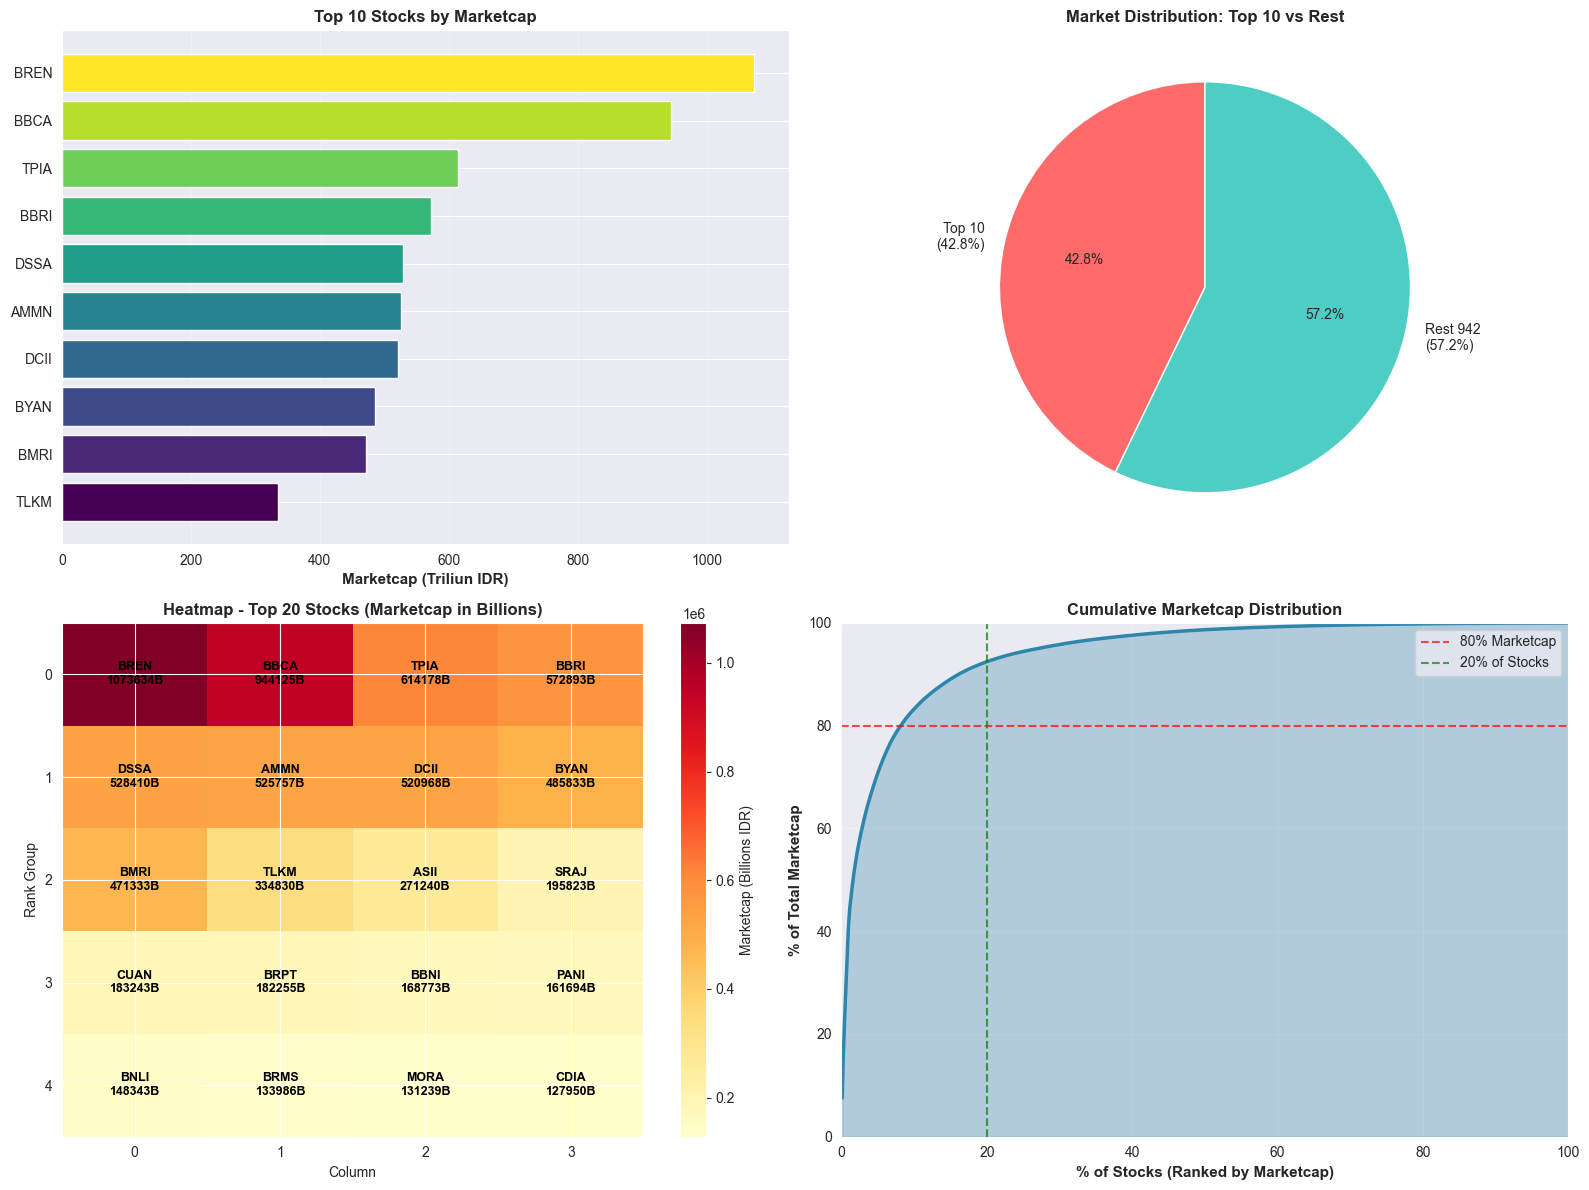


✅ Visualization complete


In [3]:
# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Bar chart - Top 10
ax1 = axes[0, 0]
top_10_sorted = top_10.sort_values('marketcap_idr')
colors = plt.cm.viridis(np.linspace(0, 1, len(top_10_sorted)))
ax1.barh(top_10_sorted['ticker'], top_10_sorted['marketcap_idr']/1e12, color=colors)
ax1.set_xlabel('Marketcap (Triliun IDR)', fontsize=11, fontweight='bold')
ax1.set_title('Top 10 Stocks by Marketcap', fontsize=12, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

# 2. Pie chart - Top 10 vs Rest
ax2 = axes[0, 1]
top_10_total = top_10['marketcap_idr'].sum()
rest_total = market_data['marketcap_idr'].sum() - top_10_total
pie_data = [top_10_total, rest_total]
pie_labels = [f'Top 10\n({top_10_total/market_data["marketcap_idr"].sum()*100:.1f}%)', 
              f'Rest {len(market_data)-10}\n({rest_total/market_data["marketcap_idr"].sum()*100:.1f}%)']
colors_pie = ['#FF6B6B', '#4ECDC4']
ax2.pie(pie_data, labels=pie_labels, autopct='%1.1f%%', colors=colors_pie, startangle=90)
ax2.set_title('Market Distribution: Top 10 vs Rest', fontsize=12, fontweight='bold')

# 3. Heatmap - Top 20 stocks (marketcap by rank)
ax3 = axes[1, 0]
top_20 = market_data.head(20).copy()
top_20['rank'] = range(1, len(top_20) + 1)
top_20['mcap_billions'] = top_20['marketcap_idr'] / 1e9

# Reshape for heatmap (5 rows x 4 cols)
heatmap_data = top_20['mcap_billions'].values.reshape(5, 4)
heatmap_tickers = top_20['ticker'].values.reshape(5, 4)

im = ax3.imshow(heatmap_data, cmap='YlOrRd', aspect='auto')
ax3.set_xticks(range(4))
ax3.set_yticks(range(5))

# Add ticker labels
for i in range(5):
    for j in range(4):
        text = ax3.text(j, i, f"{heatmap_tickers[i, j]}\n{heatmap_data[i, j]:.0f}B",
                       ha="center", va="center", color="black", fontsize=9, fontweight='bold')

ax3.set_title('Heatmap - Top 20 Stocks (Marketcap in Billions)', fontsize=12, fontweight='bold')
ax3.set_xlabel('Column', fontsize=10)
ax3.set_ylabel('Rank Group', fontsize=10)
cbar = plt.colorbar(im, ax=ax3)
cbar.set_label('Marketcap (Billions IDR)', fontsize=10)

# 4. Cumulative distribution
ax4 = axes[1, 1]
market_data_sorted = market_data.sort_values('marketcap_idr', ascending=False).reset_index(drop=True)
cumulative_mcap = market_data_sorted['marketcap_idr'].cumsum() / market_data_sorted['marketcap_idr'].sum() * 100
cumulative_pct_stocks = (np.arange(1, len(market_data_sorted) + 1) / len(market_data_sorted)) * 100

ax4.plot(cumulative_pct_stocks, cumulative_mcap, linewidth=2.5, color='#2E86AB')
ax4.fill_between(cumulative_pct_stocks, cumulative_mcap, alpha=0.3, color='#2E86AB')
ax4.axhline(y=80, color='red', linestyle='--', alpha=0.7, label='80% Marketcap')
ax4.axvline(x=20, color='green', linestyle='--', alpha=0.7, label='20% of Stocks')
ax4.set_xlabel('% of Stocks (Ranked by Marketcap)', fontsize=11, fontweight='bold')
ax4.set_ylabel('% of Total Marketcap', fontsize=11, fontweight='bold')
ax4.set_title('Cumulative Marketcap Distribution', fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3)
ax4.legend(fontsize=10)
ax4.set_xlim(0, 100)
ax4.set_ylim(0, 100)

plt.tight_layout()
plt.show()

print("\n✅ Visualization complete")

## Market Concentration Analysis

In [4]:
# Concentration metrics
market_data_sorted = market_data.sort_values('marketcap_idr', ascending=False).reset_index(drop=True)
total_mcap = market_data_sorted['marketcap_idr'].sum()

# Calculate percentiles
top_1_pct = market_data_sorted.iloc[:int(len(market_data_sorted)*0.01)]['marketcap_idr'].sum() / total_mcap * 100
top_5_pct = market_data_sorted.iloc[:int(len(market_data_sorted)*0.05)]['marketcap_idr'].sum() / total_mcap * 100
top_10_pct = market_data_sorted.iloc[:int(len(market_data_sorted)*0.10)]['marketcap_idr'].sum() / total_mcap * 100
top_20_pct = market_data_sorted.iloc[:int(len(market_data_sorted)*0.20)]['marketcap_idr'].sum() / total_mcap * 100

print("\n📊 MARKET CONCENTRATION METRICS")
print("="*50)
print(f"Top 1% of stocks ({int(len(market_data_sorted)*0.01)} stocks):   {top_1_pct:>6.2f}% of market")
print(f"Top 5% of stocks ({int(len(market_data_sorted)*0.05)} stocks):  {top_5_pct:>6.2f}% of market")
print(f"Top 10% of stocks ({int(len(market_data_sorted)*0.10)} stocks): {top_10_pct:>6.2f}% of market")
print(f"Top 20% of stocks ({int(len(market_data_sorted)*0.20)} stocks): {top_20_pct:>6.2f}% of market")
print("="*50)


📊 MARKET CONCENTRATION METRICS
Top 1% of stocks (9 stocks):    40.46% of market
Top 5% of stocks (47 stocks):   70.56% of market
Top 10% of stocks (95 stocks):  83.24% of market
Top 20% of stocks (190 stocks):  92.44% of market
